### The method used over here is that we use a sliding window and classify the bounding box whether the cropped image has truck in it or not. Then using the positive bounding boxes and KMeans, we classify pixel if it belongs truck or not.

In [1]:
import argparse
from re import I
import time

import cv2
import imutils
import numpy as np
from imutils.object_detection import non_max_suppression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

IN_COLAB = False

try:
    from google.colab.patches import cv2_imshow
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

!git clone https://github.com/openMVG/SfM_quality_evaluation

2021-12-11 04:29:07.488891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/varun/.local/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-11 04:29:07.488931: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/bin/bash: line 1: git: command not found


In [2]:
def sliding_window(image,step,ws):
    for y in range(0,image.shape[0]-ws[1],step):
        for x in range(0,image.shape[1]-ws[0],step):
            yield (x,y,image[y:y+ws[1],x:x+ws[0]])

def image_pyramid(image,scale=1.5,min_size=(30,30)):
    yield image

    while True:
        w = int(image.shape[1]/scale)
        image = imutils.resize(image,width=w)

        if image.shape[1]<min_size[0] or image.shape[0]<min_size[0]:
            break

        yield image

In [3]:
args = {'image':'SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/castle-P19/images/0009.jpg', 'size':'(100,50)','min_conf':0.85}

In [4]:
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 8
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224,224)

In [5]:
resnetModel = ResNet101V2(include_top=True,weights='imagenet')
orig = cv2.imread(args["image"])
orig = imutils.resize(orig,width=WIDTH)
(H,W) = orig.shape[:2]

179527680/179518384 [==============================] - 7s 0us/step


In [6]:
pyramid = image_pyramid(orig,scale = PYR_SCALE,min_size=ROI_SIZE)

rois = []
locs = []


In [7]:
start = time.time()

for image in pyramid:
    scale = W/float(image.shape[1])

    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        x = int(x*scale)
        y = int(y*scale)
        w = int(ROI_SIZE[0]*scale)
        h = int(ROI_SIZE[1]*scale)

        roi = cv2.resize(roiOrig,INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        rois.append(roi)
        locs.append((x, y, x+w, y+h))
        
end = time.time()

In [8]:
print("[INFO] looping over pyramid/winodws took {:.5f} seconds".format(end-start))

rois = np.array(rois,dtype="float32")
print("[INFO] Classifying ROI's")
start = time.time()
preds = resnetModel.predict(rois)
end = time.time()
print("[INFO] Classifying ROI's took {:.5f} seconds".format(end-start))

preds = decode_predictions(preds,top=1)
labels = {}

[INFO] looping over pyramid/winodws took 2.16501 seconds
[INFO] Classifying ROI's
[INFO] Classifying ROI's took 32.09545 seconds
49152/35363 [=========================================] - 0s 0us/step


In [9]:
for (i,p) in enumerate(preds):
    (imagenetID, label, prob) = p[0]
    if label=='tractor' and prob >= args["min_conf"]:
        box = locs[i]

        L = labels.get(label,[])
        L.append((box,prob))
        labels[label] = L

In [10]:
tractor_mask = cv2.imread('mask1.png')

tractor_mask = np.reshape(tractor_mask, (-1,3))
tractor_mask_bool = np.all(tractor_mask!=255, axis=1)
tractor_points = tractor_mask[tractor_mask_bool]

tractor_cluster = KMeans(20)
tractor_cluster.fit(tractor_points)
tractor_cluster_points = tractor_cluster.cluster_centers_
tractor_cluster_points = tractor_cluster_points.astype('int')

non_tractor_image = cv2.imread('SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0000.jpg')
non_tractor_points = np.reshape(non_tractor_image,(-1,3))

non_tractor_cluster = KMeans(20)
non_tractor_cluster.fit(non_tractor_points)
non_tractor_cluster_points = non_tractor_cluster.cluster_centers_
non_tractor_cluster_points = non_tractor_cluster_points.astype('int')

In [11]:
X = np.vstack((non_tractor_cluster_points, tractor_cluster_points))
y = np.array([0]*len(non_tractor_cluster_points)+[1]*len(tractor_cluster_points))

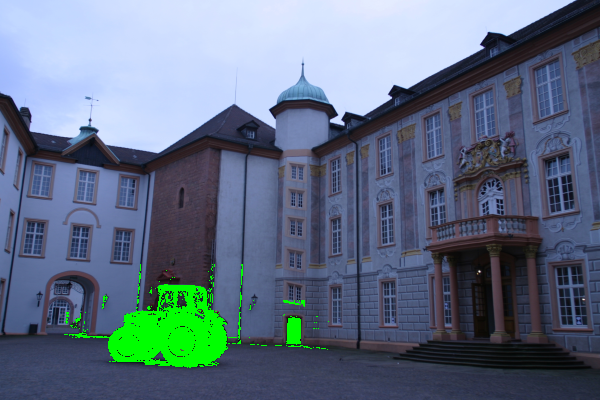

In [12]:
for label in labels:
    clone = orig.copy()
    for (box,prob) in labels[label]:
        (startX,startY,endX,endY) = box
        cv2.rectangle(clone,(startX,startY),(endX,endY),(0,255,0),2)

    clone = orig.copy()
    clone2 = orig.copy()

    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes,proba, overlapThresh=0.3)

    points_ind = []
    for (startX,startY,endX,endY) in boxes:
        cv2.rectangle(clone,(startX,startY),(endX,endY),(0,255,0),2)

        roi_points = np.mgrid[startX:endX,startY:endY].T.reshape(-1,2)

        points_ind = points_ind + roi_points.tolist()
        text_y = startY - 10 if startY - 10 >10 else startY + 10

        cv2.putText(clone,label,(startX,text_y),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0,255,0),1)
    
    
    points_ind = np.unique(points_ind, axis=0)

    x_ind, y_ind = np.split(points_ind,2,axis=1)
    x_ind, y_ind = x_ind.squeeze(), y_ind.squeeze()
    points = orig[(y_ind, x_ind)]
    
    kNN = KNeighborsClassifier(n_neighbors=1)
    kNN.fit(X,y)
    pixel_label = kNN.predict(points)

    x_ind = x_ind[pixel_label==1]
    y_ind = y_ind[pixel_label==1]

    clone2[(y_ind,x_ind)] = [0,255,0]

if IN_COLAB:
    cv2_imshow(clone2)
else:
    plt.imshow(clone2)